### Canny Edge detector from scratch

#### 5 Steps:
<ol>
    <li>Noise Reduction - Gaussian Filter</li>
    <li>Gradient Calculation</li>
    <li>Non-maximum Suppression</li>
    <li>Double Threshold to determine potential edges</li>
    <li>Edge Tracking by Hysterises</li>
</ol>

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy import ndimage
import time

#### Step 0: Load and display image

In [2]:
img = rgb2gray(np.array(cv2.imread("building.tif"))) #normalize to [0 - 1]

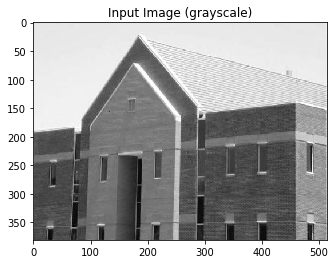

In [3]:
plt.imshow(img, 'gray')
plt.title("Input Image (grayscale)")
plt.show()

#### Step 1:  Blur the image with Gaussian filter for different values of σ

In [4]:
def G(img, sigma):
    """Gaussian Filter"""
    return ndimage.gaussian_filter(img, sigma)

In [5]:
sigmas = [2, 8, 16]
blurred = [G(img, v) for v in sigmas]

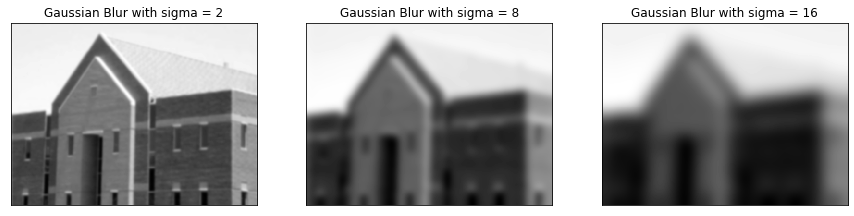

In [6]:
### display images
plt.figure(figsize=(15, 15))
for i in range(len(sigmas)):
    plt.subplot(1, len(sigmas), i+1), plt.imshow(blurred[i], 'gray')
    plt.title("Gaussian Blur with sigma = " + str(sigmas[i]))
    plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.show()

#### Step 2: Calculate Gradient magnitudes and directions

In [7]:
def normalize(img):
    """Normalize image to [0 - 1]"""
    return img/img.max()

In [8]:
def sobel_filter(img, direction):
    """
    Implement Sobel Filter to compute the derivitive of gaussian.
    @Param:
    1. img - gaussian blur image.
    2. direction - 'x' or 'y' for calculating Sobel operator w.r.t x/y
    """
    if(direction == 'x'):
        sobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        filter = ndimage.convolve(img, sobelX)
    elif(direction == 'y'):
        sobelY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        filter = ndimage.convolve(img, sobelY)
    else:
        raise ValueError("Direction should be either 'x' or 'y', found: " + str(direction))
        
    return normalize(filter)

In [9]:
def image_gradient(img):
    """
    Calculates the Magnitude and Angle of gaussian filtered images using Sobel operator
    i.e. 1st derivitive of Gaussians.
    @Param:
    1. img - gaussian filtered image.
    @Returns:
    1. magnitude - Magnitude of gradient image
    2. angle - angle maxtrix of gradient image
    3. gradient['x'] : Gradient in the x direction, using Sobel filter.
    4. gradient['y'] : Gradient in the y direction, using Sobel filter.
    """
    dx = sobel_filter(img, 'x')
    dy = sobel_filter(img, 'y')
    magnitude = np.hypot(dx, dy)
    magnitude = magnitude / magnitude.max() * 255
    angle = np.arctan2(dy,dx) #Array of angles in degrees, in the range [0, 360]. 
    return magnitude, angle, {'x': dx, 'y': dy}

In [10]:
gradients = [] #magnitude and angles of images
for gaussian_img in blurred:
    mag, angle, gradient = image_gradient(gaussian_img)
    gradients.append(mag)
    gradients.append(angle)
    
assert(len(gradients) == 2*len(blurred))

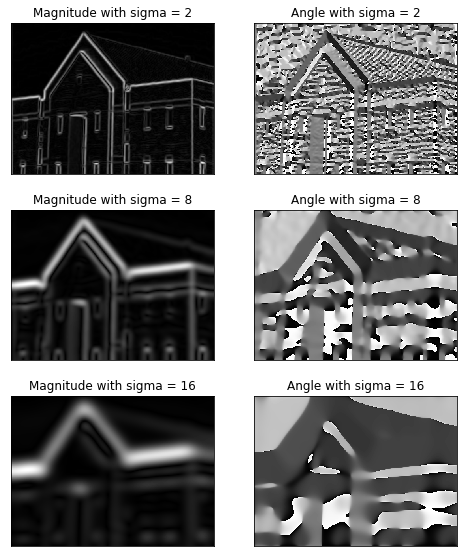

In [11]:
### display images
plt.figure(figsize=(8, 20))
for i in range(len(gradients)):
    plt.subplot(len(gradients), 2, i+1), plt.imshow(gradients[i], 'gray')
    title = ["Magnitude ", "Angle "]
    plt.title(title[i % 2] + "with sigma = " + str(sigmas[i//2]))
    plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.show()

#### Step 3: Non-maximum Suppression
<p>Basic Idea: If a pixel is not a maximum, suppress it</p>

In [12]:
## if gradient orientation is b/w 22.5 - 67.5 degrees:
##>> change is occuring from top left corner to bottom right corner (diagonal #1).

## if gradient orientation is b/w 67.5 - 112.5 degrees:
##>> change is occuring from top to bottom.

## if gradient orientation is b/w 112.5 - 157.5 degrees:
##>> change is occuring from top right corner to bottom left corner (diagonal #2).

## if gradient orientation is b/w 157.5 - 180 or 0 - 22.5 degrees:
##>> change is occuring from left to right.

In [13]:
def non_max_suppression(img, D):
    """Compute the non-max suppression (w/o interpolation) of a gaussian blurred image"""
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi #convert to angle
    angle[angle < 0] += 180 #set to [0 - 180] for all angles
    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255

           #angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = img[i, j+1]
                r = img[i, j-1]
                
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
                
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
                
            #angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if (img[i,j] >= q) and (img[i,j] >= r):
                Z[i,j] = img[i,j]
            
    return Z

In [14]:
#Compute Non-max suppression for each gaussian filtered image
nms = []
for i in range(0, len(gradients), 2):
    output = non_max_suppression(gradients[i], gradients[i + 1])
    nms.append(output)

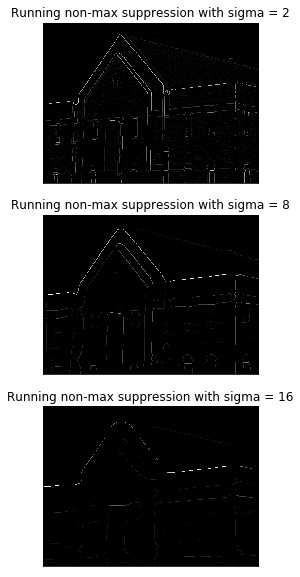

In [15]:
### display images
plt.figure(figsize=(10, 10))
for i in range(len(nms)):
    plt.subplot(len(nms), 1, i+1), plt.imshow(nms[i], 'gray')
    plt.title("Running non-max suppression with sigma = " + str(sigmas[i]))
    plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.show()

#### Step 4: Thresholding with Hysteresis

In [16]:
## the point of thresholding is to reduce false edge points. This is done using a low and high threshold.
## According to the paper, threshold ratio (T_h : T_l) should be in the range 2:1 - 3:1.

#Done in 2 parts: 
#>! Double Thresholding
#>! Hysteresis

In [17]:
def double_thresholding(nms_image, T_l, T_h):
    """
    Performs double thresholding.
    @Param: 
    1. nms_image - Non max suppression image
    2. T_l - Low Threshold.
    3. T_h - High Threshold.
    NOTE: T_h/T_l ⊆ [2 - 3]
    @Return:
    - thresholded_image := Process of applying Double Thresholding to Non-Max suppressed image.
    """
    if(T_h/T_l > 3 or T_h/T_l < 2):
        raise Exception("Incorrect ratio: T_h/T_l ⊆ [2 - 3], your ratio was: " + str(T_h/T_l))
    
    thresholded = np.zeros(nms_image.shape) #thresholding output
    n, m = nms_image.shape #get height and width
    
    for i in range(n - 1):
        for j in range(m - 1):
            intensity = nms_image[i, j]
            if(intensity >= T_h): #higher than Threshold hight, strong edge!
                thresholded[i, j] = 255
            elif(T_h > intensity >= T_l): #weak edge
                thresholded[i, j] = 128 #default to weak edge
                
    return thresholded           

In [18]:
def hysteresis(nms, T_l, T_h):
    """
    Performs hysteresis on a double thresholded image.
    1. nms - Non-max suppression image (will compute its threshold)
    2. T_l - Low Threshold.
    3. T_h - High Threshold.
    NOTE: T_h/T_l ⊆ [2 - 3]
    @Param: 
    1. thresholded_image - Double thresholding applied to non-max suppression.
    """
    thresholded_image = double_thresholding(nms, T_l, T_h) #calculate double threshold
    
    h_out = np.zeros(thresholded_image.shape)
    n, m = h_out.shape #get dimensions
    
    for i in range(n):
        for j in range(m):
            intensity = thresholded_image[i, j]
            if(intensity == 255):
                h_out[i,j] = 255
            elif(intensity == 128):#check for strong edges
                #check all 8 neighbors, if any or them are a strong edge, mark ME as strong edge too.
                diagonal_right = np.sum(thresholded_image.diagonal()[i-1:i+2] == 255.0)
                diagonal_left = np.sum(np.fliplr(thresholded_image).diagonal()[i-1:i+2] == 255.0)
                left_right = np.sum(thresholded_image[i-1:i+2,j] == 255.0) #left - right
                top_bottom = np.sum(thresholded_image[i,j-1:j+2] == 255.0) #top - bottom
                if(diagonal_left + diagonal_right + left_right + top_bottom >= 1): #found strong edge connection
                    h_out[i, j] = 255
    return h_out

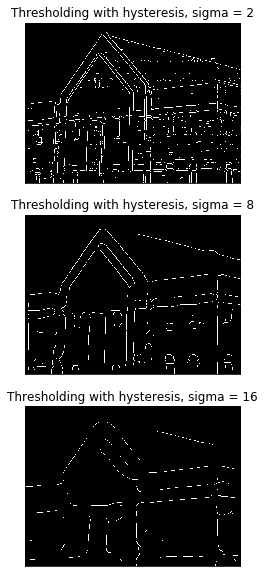

In [19]:
### display images
plt.figure(figsize=(10, 10))
for i in range(len(nms)):
    output = hysteresis(nms[i].copy(), 10, 20)
    plt.subplot(len(nms), 1, i+1), plt.imshow(output, 'gray')
    plt.title("Thresholding with hysteresis, sigma = " + str(sigmas[i]))
    plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.show()

## Built-in Canny Edge Detector (openCV2)

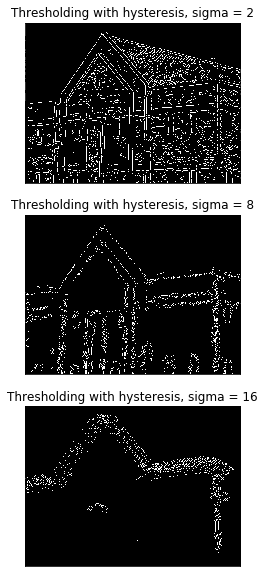

In [20]:
### display images
plt.figure(figsize=(10, 10))
for i in range(len(blurred)):
    img = blurred[i].copy()
    img *= 255
    img = img.astype(np.uint8) #convert back to [0 - 255]
    canny = cv2.Canny(img, 7, 14)
    plt.subplot(len(nms), 1, i+1), plt.imshow(canny, 'gray')
    plt.title("Thresholding with hysteresis, sigma = " + str(sigmas[i]))
    plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.show()